In [6]:
import torch 
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy


class ImageClassNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 7*7*256, out_features = 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 512, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 10)
        )
        
        self.init_weight()

    def init_weight(self):
        for layer in self.model:
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_uniform_(layer.weight, mode = 'fan_out', nonlinearity = 'relu')
                # nn.init.normal_(layer.weight, 0, std= 0.01)
                nn.init.constant_(layer.bias, 0)
            if isinstance(layer, nn.Linear):
                # nn.init.normal_(layer.weight, 0, std= 0.01)
                nn.init.kaiming_uniform_(layer.weight, mode = 'fan_out', nonlinearity = 'relu')
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        return self.model(x)
    



In [7]:
def main_worker():
    model = ImageClassNet()
    model.cuda()
    # optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay=5e-4)
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
    criterion = nn.CrossEntropyLoss().to('cuda')
    
    train_trans = v2.Compose([
        v2.RGB(),
        # v2.Normalize(mean = [0.1307, 0.1307, 0.1307], std = [0.3081, 0.3081, 0.3081]),
        v2.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.5, hue = 0.5),
        v2.RandomInvert(p = 0.5),
        v2.RandomRotation(degrees = (0,15)),
        v2.RandomPerspective(distortion_scale = 0.3, p = 0.5),
        v2.GaussianBlur(kernel_size = 3, sigma = (0.1, 2.0)),
        v2.ToTensor(),
         ])
    
    val_trans = v2.Compose([
        v2.RGB(),
        # v2.Normalize(mean = [0.1307, 0.1307, 0.1307], std = [0.3081, 0.3081, 0.3081]),
        v2.RandomInvert(p = 0.5),
        v2.GaussianBlur(kernel_size = 3, sigma = (0.1, 2.0)),
        v2.ToTensor(),
    ])
    
    train_ds = datasets.MNIST(root = './Datasets', train = True, download = True, transform = train_trans)
    val_ds = datasets.MNIST(root = './Datasets', train = False, download = True, transform = val_trans)
    
    trainloader = torch.utils.data.DataLoader(train_ds, batch_size = 64, shuffle = True, pin_memory= True, num_workers = 6)
    valloader = torch.utils.data.DataLoader(val_ds, batch_size = 64, shuffle = False, pin_memory= True, num_workers = 6)
    
    import matplotlib.pyplot as plt

    # View the images in the dataset
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Plot the images
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(f"Label: {labels[i]}", fontsize = 8)
        ax.axis('off')

    plt.show()
    
    for times in range(10,15):
        model = ImageClassNet()
        model.cuda()
        # optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay=5e-4)
        optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
        criterion = nn.CrossEntropyLoss().to('cuda')
        best_accuracy = 0.0
        best_model_state_dict = None

        
        for epoch in range(75):
            
            model.train()
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.cuda(), labels.cuda()
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                if i % 100 == 99:
                    print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 100}')
                    running_loss = 0.0
                    
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                total_loss = 0.0
                total = 0
                correct = 0
                
                for data in valloader:
                    inputs, labels = data
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)  # Assuming loss_function is defined
                    
                    total_loss += loss.item()
                    
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                
                accuracy = 100 * correct / total
                avg_loss = total_loss / len(valloader)
                
                print(f'Accuracy of the network on the test images: {accuracy:.2f}%')
                print(f'Validation Loss: {avg_loss:.4f}')
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state_dict = model.state_dict()
                torch.save(best_model_state_dict, 'best_model' + str(times) + '.pth')
        
        torch.save(model.state_dict(), "final_model" + str(times) + '.pth')
        
        

c:\Users\levie\.pyenv\pyenv-win\versions\3.11.8\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


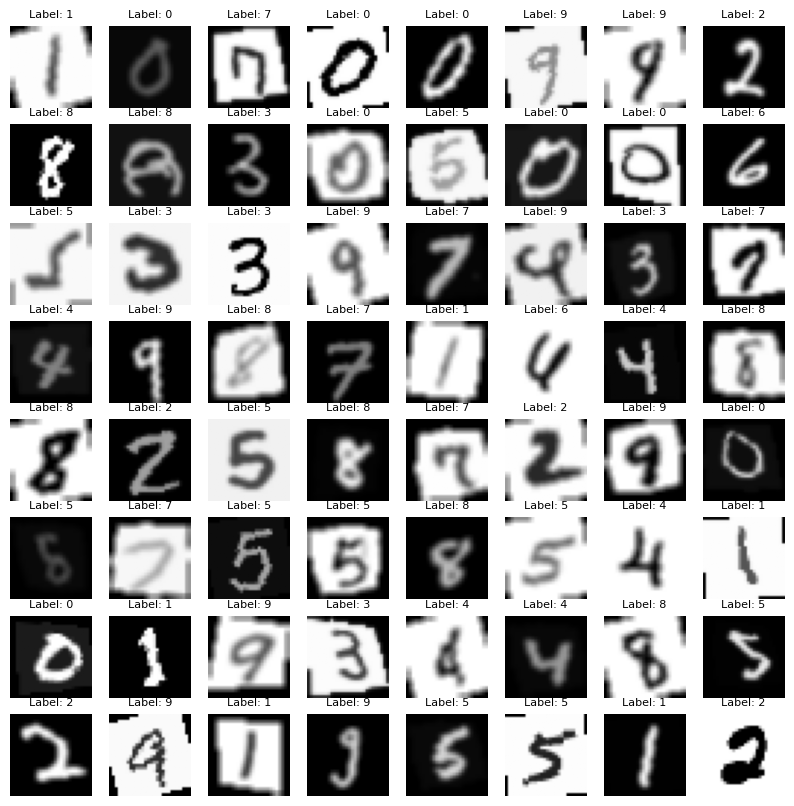

[1, 100] loss: 2.497944719791412
[1, 200] loss: 1.126022107899189
[1, 300] loss: 0.5070300460234285
[1, 400] loss: 0.3686087863147259
[1, 500] loss: 0.2957940795272589
[1, 600] loss: 0.2738694138079882
[1, 700] loss: 0.24454775087535383
[1, 800] loss: 0.209146021977067
[1, 900] loss: 0.2187249931693077
Accuracy of the network on the test images: 97.73%
Validation Loss: 0.0688
[2, 100] loss: 0.1881489010900259
[2, 200] loss: 0.17567630354315042
[2, 300] loss: 0.18332933329045772
[2, 400] loss: 0.18938426304608583
[2, 500] loss: 0.15727760296314955
[2, 600] loss: 0.16382089864462615
[2, 700] loss: 0.15490828918293117
[2, 800] loss: 0.13179584523662924
[2, 900] loss: 0.13937807857990264
Accuracy of the network on the test images: 98.45%
Validation Loss: 0.0481
[3, 100] loss: 0.13929219074547292
[3, 200] loss: 0.14389899861998856
[3, 300] loss: 0.13626379205845296
[3, 400] loss: 0.14176292454823852
[3, 500] loss: 0.1233286017458886
[3, 600] loss: 0.14037178380414844
[3, 700] loss: 0.135582

In [8]:
main_worker()